# Project 59 Shape Classification

## Authors: Julen Etxaniz and Ibon Urbina

## Objectives: The goal of the project is to compare different classification algorithms on the solution of plane and car shape datasets. 

## What is done in the Notebook: 
### [1.Importing the libraries](#1.-Importing-the-libraries)
### [2.Reading the datasets](#2.-Reading-the-datasets)
### [3.Processing the datasets](#3.-Preprocessing-the-datasets)
### [4.Preparing data for classification](#4.-Preparing-data-for-classification)
### 5.Dividing dataset in train and test sets for validation
### 6.Defining the classifiers
### 7.Learning the classifiers
### 8.Using the classifier for predictions

# 1. Importing the libraries
 We start by importing all relevant libraries to be used in the notebook.
    

In [187]:
# Enables interaction with the plots
%matplotlib notebook
import os
import matplotlib.pyplot as plt
from scipy.io import loadmat
import re

import pandas as pd
import numpy as np

from scipy.ndimage import gaussian_filter
from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from tpot import TPOTClassifier
from sklearn.feature_selection import SelectKBest, chi2

from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE

# 2. Reading the datasets
We read the plane and car datasets

In [61]:
def read_mats(dir):
    mats = []
    mats_file_name = []

    files = os.listdir(dir)
    # Files ordered before appending to maintain same order
    sorted_files = sorted(files)
    for file in sorted_files:
        mats.append(loadmat(dir + file))
        # To know in which order are we reading the files
        mats_file_name.append(file)
    
    return mats, mats_file_name

## 2.1. Reading the plane dataset
We read the 210 files that contain the instances of the plane classification problem.

We concatenate all the instances in a unique dataframe called "plane_mats".

In [62]:
plane_dir = "shape_data/plane_data/"
plane_mats, plane_mats_file_name = read_mats(plane_dir)

We plot one plane of each shape.

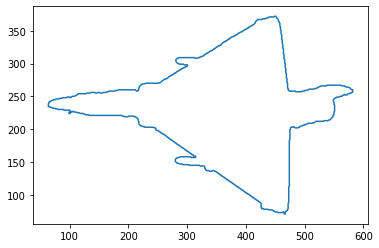

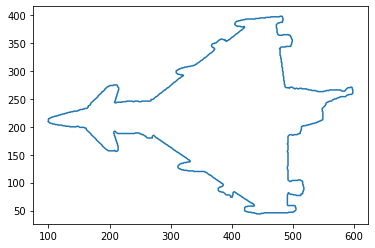

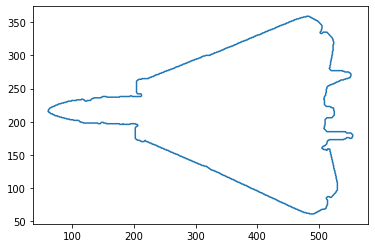

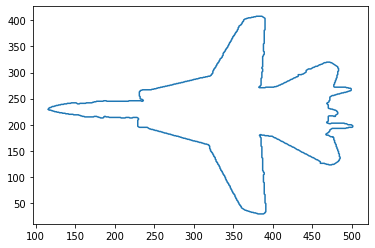

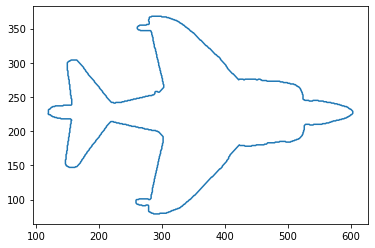

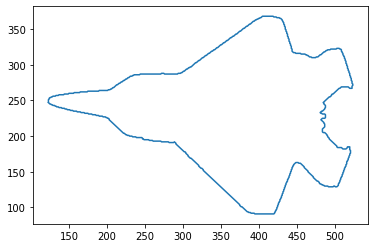

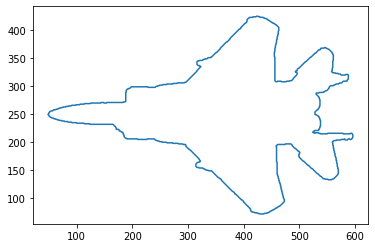

In [63]:
for i in range(7):
    plane = plane_mats[i*30]
    x = plane['x'][:,0]
    y = plane['x'][:,1]
    plt.plot(x, y)
    plt.show()

We check the dataset is correct, looking at the number of samples

In [64]:
print('The number of samples in the plane dataset is', len(plane_mats))

The number of samples in the plane dataset is 210


## 2.2. Reading the car dataset
We read the 120 files that contain the instances of the car classification problem.

We concatenate all the instances in a unique dataframe called "car_mats"

In [65]:
# Ibon
car_dir = "shape_data/car_data/"
car_mats, car_mats_file_name = read_mats(car_dir)

We check the dataset is correct, looking at the number of samples

In [66]:
print('The number of samples in the car dataset is', len(car_mats))

The number of samples in the car dataset is 120


# 3. Preprocessing the datasets

One of the best ways to represent data are pandas DataFrames. Either for their flexibility and eassy management of information. That's what we are going to do in the next cell: convert the list where we read all the data to a DataFrame.

In [67]:
def get_dataframe(mats):
    df = pd.DataFrame(mats)
    df
    df = df.drop(['__header__', '__version__', '__globals__'], axis=1)
    df
    return df

In [68]:
# Remember we have the names of the files read (in order) in our list called 
# Lets, divide that array in two arrays. One containing the class number and the other the sample number.

def get_samples_classes(mats_file_name):
    sample_n = []
    class_n = []

    for i in mats_file_name:
        class_n.append(int(re.findall(r'\d+', str(i))[0]))
        sample_n.append(int(re.findall(r'\d+', str(i))[1]))
    
    return sample_n, class_n

In [69]:
def print_class_count(df):
    print("Quantity of samples in each class:")
    print(df['Class'].value_counts())

In [70]:
def add_perimeter(df):
    length_list = []
    for i in range(len(df)):
        length_list.append(len(df['x'][i]))

    df['Perimeter_length'] = length_list
    
    return df

In [71]:
def separate_coordinates(df):
    x_coordinates = []
    y_coordinates = []

    for i in range(len(df['x'])):
        x_coordinates.append(np.resize((df['x'][i])[:,0], (300, 1)))
        y_coordinates.append(np.resize((df['x'][i])[:,1], (300, 1)))
    
    return x_coordinates, y_coordinates

In [72]:
def get_stacks(x_coordinates, y_coordinates):
    x_stack = x_coordinates[0]
    y_stack = y_coordinates[0]
    
    for i in range(len(x_coordinates)-1):
        x_stack = np.column_stack((x_stack, x_coordinates[i+1]))
        y_stack = np.column_stack((y_stack, y_coordinates[i+1]))
    
    return x_stack, y_stack

In [73]:
# Insert those columns in the dataFrame
def insert_columns(df, x_stack, y_stack):
    for i in range(len(x_stack)):
        stringX = "x" + str(i)
        stringY = "y" + str(i)
        df[stringX] = x_stack[i]
        df[stringY] = y_stack[i]
        
    return df

## 3.1. Preprocessing the plane dataset

In this problem there are four classes that correspond to the 7 types of planes: (a) Mirage, (b) Eurofighter, (c) F-14 wings closed, (d) F-14 wings opened, (e) Harrier, (f) F-22, (g) F-15. However, in the database files are written like this: "ClassX_SampleY.mat", where X is the corresponding class number and Y the corresponding sample number. 

Here is the correspondance of class number and class name (plane model name):
* number 1 = Mirage
* number 2 = Eurofighter
* number 3 = F-14 wings closed
* number 4 = F-14 wings opened
* number 5 = Harrier
* number 6 = F-22
* number 7 = F-15

In [74]:
plane_df = get_dataframe(plane_mats)
plane_df

,x
0,"[[64, 235], [65, 234], [66, 234], [67, 234], [..."
1,"[[60, 139], [61, 138], [62, 137], [63, 137], [..."
2,"[[60, 219], [61, 218], [62, 217], [63, 217], [..."
3,"[[54, 201], [55, 200], [55, 199], [56, 198], [..."
4,"[[64, 275], [65, 274], [66, 274], [67, 274], [..."
...,...
205,"[[33, 234], [34, 233], [35, 232], [36, 231], [..."
206,"[[21, 155], [22, 154], [23, 153], [24, 152], [..."
207,"[[45, 324], [46, 323], [47, 322], [48, 321], [..."
208,"[[70, 255], [71, 254], [72, 254], [73, 253], [..."


In [75]:
plane_sample_n, plane_class_n = get_samples_classes(plane_mats_file_name)

In [76]:
# Ibon
print("This is how our sample_n looks like: \n")
np.array(plane_sample_n)

This is how our sample_n looks like: 



array([ 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29,  3, 30,  4,  5,  6,  7,  8,  9,  1, 10, 11, 12,
       13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23, 24, 25, 26, 27, 28,
       29,  3, 30,  4,  5,  6,  7,  8,  9,  1, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19,  2, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29,  3, 30,  4,
        5,  6,  7,  8,  9,  1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29,  3, 30,  4,  5,  6,  7,  8,
        9,  1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23,
       24, 25, 26, 27, 28, 29,  3, 30,  4,  5,  6,  7,  8,  9,  1, 10, 11,
       12, 13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23, 24, 25, 26, 27,
       28, 29,  3, 30,  4,  5,  6,  7,  8,  9,  1, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19,  2, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29,  3, 30,
        4,  5,  6,  7,  8,  9])

In [77]:
# Ibon
print("This is how our class_n looks like: \n")
np.array(plane_class_n)

This is how our class_n looks like: 



array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7])

Lets add those lists to the car DataFrame.

In [78]:
# Ibon
plane_df['Class'] = plane_class_n
plane_df['Sample'] = plane_sample_n
print("This is, finally, how our plane dataFrame looks like: \n")
plane_df

This is, finally, how our plane dataFrame looks like: 



,x,Class,Sample
0,"[[64, 235], [65, 234], [66, 234], [67, 234], [...",1,1
1,"[[60, 139], [61, 138], [62, 137], [63, 137], [...",1,10
2,"[[60, 219], [61, 218], [62, 217], [63, 217], [...",1,11
3,"[[54, 201], [55, 200], [55, 199], [56, 198], [...",1,12
4,"[[64, 275], [65, 274], [66, 274], [67, 274], [...",1,13
...,...,...,...
205,"[[33, 234], [34, 233], [35, 232], [36, 231], [...",7,5
206,"[[21, 155], [22, 154], [23, 153], [24, 152], [...",7,6
207,"[[45, 324], [46, 323], [47, 322], [48, 321], [...",7,7
208,"[[70, 255], [71, 254], [72, 254], [73, 253], [...",7,8


### Classes are balanced? Yes

Although in the description of the database it is said that each class has 30 samples, to make sure about it we are going to count them.

In [79]:
print_class_count(plane_df)

Quantity of samples in each class:
7    30
6    30
5    30
4    30
3    30
2    30
1    30
Name: Class, dtype: int64


### Let's add another feature to our database

As we mention before, the only feature descriptor of the shapes is x, which  which refers to cartesian coordinates of each point on the perimeter of the shape. However, how many points are in each contour perimeter is not taken as a unique feature. It is implicitly measure in the length of each x sample, but, we prefer make it explicit.

In [80]:
plane_df = add_perimeter(plane_df)

In [81]:
print("This is how our plane dataFrame looks like: \n")
plane_df

This is how our plane dataFrame looks like: 



,x,Class,Sample,Perimeter_length
0,"[[64, 235], [65, 234], [66, 234], [67, 234], [...",1,1,1433
1,"[[60, 139], [61, 138], [62, 137], [63, 137], [...",1,10,1540
2,"[[60, 219], [61, 218], [62, 217], [63, 217], [...",1,11,1587
3,"[[54, 201], [55, 200], [55, 199], [56, 198], [...",1,12,1511
4,"[[64, 275], [65, 274], [66, 274], [67, 274], [...",1,13,1489
...,...,...,...,...
205,"[[33, 234], [34, 233], [35, 232], [36, 231], [...",7,5,1801
206,"[[21, 155], [22, 154], [23, 153], [24, 152], [...",7,6,1943
207,"[[45, 324], [46, 323], [47, 322], [48, 321], [...",7,7,1876
208,"[[70, 255], [71, 254], [72, 254], [73, 253], [...",7,8,1661


### Changing how x feature is represented

When learning a classifier is useful to have features as arrays of numbers, and not as arrays of sequences. In our case, x is an array of (x, y) coordinates; so we are going to separate x and y, an then create two extra features from there.

In [82]:
x_coordinates, y_coordinates = separate_coordinates(plane_df)
x_stack, y_stack = get_stacks(x_coordinates, y_coordinates)
plane_df = insert_columns(plane_df, x_stack, y_stack)
plane_df

,x,Class,Sample,Perimeter_length,x0,y0,x1,y1,x2,y2,...,x295,y295,x296,y296,x297,y297,x298,y298,x299,y299
0,"[[64, 235], [65, 234], [66, 234], [67, 234], [...",1,1,1433,64,235,65,234,66,234,...,288,158,287,157,286,157,285,157,284,157
1,"[[60, 139], [61, 138], [62, 137], [63, 137], [...",1,10,1540,60,139,61,138,62,137,...,343,131,342,131,341,131,340,131,339,131
2,"[[60, 219], [61, 218], [62, 217], [63, 217], [...",1,11,1587,60,219,61,218,62,217,...,320,140,319,140,318,140,317,140,316,140
3,"[[54, 201], [55, 200], [55, 199], [56, 198], [...",1,12,1511,54,201,55,200,55,199,...,287,121,286,121,285,121,284,120,283,119
4,"[[64, 275], [65, 274], [66, 274], [67, 274], [...",1,13,1489,64,275,65,274,66,274,...,283,148,284,148,285,147,286,147,287,147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,"[[33, 234], [34, 233], [35, 232], [36, 231], [...",7,5,1801,33,234,34,233,35,232,...,306,151,307,150,308,149,309,148,309,147
206,"[[21, 155], [22, 154], [23, 153], [24, 152], [...",7,6,1943,21,155,22,154,23,153,...,281,164,282,164,283,164,284,164,285,164
207,"[[45, 324], [46, 323], [47, 322], [48, 321], [...",7,7,1876,45,324,46,323,47,322,...,291,190,292,189,292,188,293,187,294,186
208,"[[70, 255], [71, 254], [72, 254], [73, 253], [...",7,8,1661,70,255,71,254,72,254,...,326,175,327,174,328,174,329,173,330,173


## 3.2. Preprocessing the car dataset

In this problem there are four classes that correspond to the 4 types of cars:  sedan, pickup, minivan, or SUV. However, in the database files are written like this: "ClassX_SampleY.mat", where X is the corresponding class number and Y the corresponding sample number. 

Here is the correspondance of class number and class name (car model name):
* number 1 = sedan
* number 2 = pickup
* number 3 = minivan
* number 4 = SUV

One of the best ways to represent data are pandas DataFrames. Either for their flexibility and eassy management of information. That's what we are going to do in the next cell: convert the list where we read all the car data to a DataFrame called car_df.

In [83]:
# Ibon
car_df = pd.DataFrame(car_mats)

This is the way car_df DataFrame looks like:


In [84]:
# Ibon
car_df

,__header__,__version__,__globals__,x
0,"b'MATLAB 5.0 MAT-file, Platform: PCWIN, Create...",1.0,[],"[[113, 181], [114, 180], [114, 179], [114, 178..."
1,"b'MATLAB 5.0 MAT-file, Platform: PCWIN, Create...",1.0,[],"[[98, 180], [99, 179], [99, 178], [100, 177], ..."
2,"b'MATLAB 5.0 MAT-file, Platform: PCWIN, Create...",1.0,[],"[[70, 180], [71, 180], [72, 179], [73, 178], [..."
3,"b'MATLAB 5.0 MAT-file, Platform: PCWIN, Create...",1.0,[],"[[54, 184], [55, 183], [56, 183], [57, 183], [..."
4,"b'MATLAB 5.0 MAT-file, Platform: PCWIN, Create...",1.0,[],"[[44, 180], [45, 179], [46, 179], [47, 178], [..."
...,...,...,...,...
115,"b'MATLAB 5.0 MAT-file, Platform: PCWIN, Create...",1.0,[],"[[101, 182], [102, 182], [103, 182], [104, 182..."
116,"b'MATLAB 5.0 MAT-file, Platform: PCWIN, Create...",1.0,[],"[[46, 180], [47, 180], [48, 179], [48, 178], [..."
117,"b'MATLAB 5.0 MAT-file, Platform: PCWIN, Create...",1.0,[],"[[31, 173], [32, 173], [33, 174], [34, 174], [..."
118,"b'MATLAB 5.0 MAT-file, Platform: PCWIN, Create...",1.0,[],"[[20, 170], [21, 171], [22, 170], [23, 170], [..."


As we see in the image above, __header__, __version__ and __globals__ columns are values created when using loadmat function to be able to read .mat files.

Those columns are not useful. We are going to delete them.

In [85]:
# Ibon
car_df = car_df.drop(['__header__', '__version__', '__globals__'], axis=1)
car_df

,x
0,"[[113, 181], [114, 180], [114, 179], [114, 178..."
1,"[[98, 180], [99, 179], [99, 178], [100, 177], ..."
2,"[[70, 180], [71, 180], [72, 179], [73, 178], [..."
3,"[[54, 184], [55, 183], [56, 183], [57, 183], [..."
4,"[[44, 180], [45, 179], [46, 179], [47, 178], [..."
...,...
115,"[[101, 182], [102, 182], [103, 182], [104, 182..."
116,"[[46, 180], [47, 180], [48, 179], [48, 178], [..."
117,"[[31, 173], [32, 173], [33, 174], [34, 174], [..."
118,"[[20, 170], [21, 171], [22, 170], [23, 170], [..."


Now, the only attribute available in our car DataFrame is x, which refers to cartesian coordinates of each point on the perimeter of the shape. We need more information to include there, such as class value and sample number.

In [86]:
# Ibon
# Remember we have the names of the files read (in order) in our list called car_mats_file_name.
# Lets, divide that array in two arrays. One containing the class number and the other the sample number.
car_sample_n, car_class_n = get_samples_classes(car_mats_file_name)

In [87]:
# Ibon
print("This is how our sample_n looks like: \n")
np.array(car_sample_n)

This is how our sample_n looks like: 



array([ 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29,  3, 30,  4,  5,  6,  7,  8,  9,  1, 10, 11, 12,
       13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23, 24, 25, 26, 27, 28,
       29,  3, 30,  4,  5,  6,  7,  8,  9,  1, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19,  2, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29,  3, 30,  4,
        5,  6,  7,  8,  9,  1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29,  3, 30,  4,  5,  6,  7,  8,
        9])

In [88]:
# Ibon
print("This is how our class_n looks like: \n")
np.array(car_class_n)

This is how our class_n looks like: 



array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

Lets add those lists to the car DataFrame.

In [89]:
# Ibon
car_df['Class'] = car_class_n
car_df['Sample'] = car_sample_n
print("This is, finally, how our car dataFrame looks like: \n")
car_df

This is, finally, how our car dataFrame looks like: 



,x,Class,Sample
0,"[[113, 181], [114, 180], [114, 179], [114, 178...",1,1
1,"[[98, 180], [99, 179], [99, 178], [100, 177], ...",1,10
2,"[[70, 180], [71, 180], [72, 179], [73, 178], [...",1,11
3,"[[54, 184], [55, 183], [56, 183], [57, 183], [...",1,12
4,"[[44, 180], [45, 179], [46, 179], [47, 178], [...",1,13
...,...,...,...
115,"[[101, 182], [102, 182], [103, 182], [104, 182...",4,5
116,"[[46, 180], [47, 180], [48, 179], [48, 178], [...",4,6
117,"[[31, 173], [32, 173], [33, 174], [34, 174], [...",4,7
118,"[[20, 170], [21, 171], [22, 170], [23, 170], [...",4,8


### Classes are balanced? Yes

Although in the description of the database it is said that each class has 30 samples, to make sure about it we are going to count them.

In [90]:
print_class_count(car_df)

Quantity of samples in each class:
4    30
3    30
2    30
1    30
Name: Class, dtype: int64


### Let's add another feature to our database

As we mention before, the only feature descriptor of the shapes is x, which  which refers to cartesian coordinates of each point on the perimeter of the shape. However, how many points are in each contour perimeter is not taken as a unique feature. It is implicitly measure in the length of each x sample, but, we prefer make it explicit.

In [91]:
car_df = add_perimeter(car_df)

In [92]:
print("This is how our car dataFrame looks like: \n")
car_df

This is how our car dataFrame looks like: 



,x,Class,Sample,Perimeter_length
0,"[[113, 181], [114, 180], [114, 179], [114, 178...",1,1,310
1,"[[98, 180], [99, 179], [99, 178], [100, 177], ...",1,10,331
2,"[[70, 180], [71, 180], [72, 179], [73, 178], [...",1,11,344
3,"[[54, 184], [55, 183], [56, 183], [57, 183], [...",1,12,334
4,"[[44, 180], [45, 179], [46, 179], [47, 178], [...",1,13,322
...,...,...,...,...
115,"[[101, 182], [102, 182], [103, 182], [104, 182...",4,5,373
116,"[[46, 180], [47, 180], [48, 179], [48, 178], [...",4,6,358
117,"[[31, 173], [32, 173], [33, 174], [34, 174], [...",4,7,374
118,"[[20, 170], [21, 171], [22, 170], [23, 170], [...",4,8,356


### Changing how x feature is represented

When learning a classifier is useful to have features as arrays of numbers, and not as arrays of sequences. In our case, x is an array of (x, y) coordinates; so we are going to separate x and y, an then create two extra features from there.

In [93]:
x_coordinates, y_coordinates = separate_coordinates(car_df)
x_stack, y_stack = get_stacks(x_coordinates, y_coordinates)
car_df = insert_columns(car_df, x_stack, y_stack)
len(car_df['x'][0])

310

# 4. Preparing data for classification

To learn the classifiers, we need to separate in two different sets the features and the classes. 


## 4.2. Preparing the plane data

In [94]:
# The selected features are: 'Perimeter_length', 'xJ' and 'yJ'  (J -> [0, 299])
plane_features = plane_df.drop(columns=['x', 'Class', 'Sample'])
plane_features

,Perimeter_length,x0,y0,x1,y1,x2,y2,x3,y3,x4,...,x295,y295,x296,y296,x297,y297,x298,y298,x299,y299
0,1433,64,235,65,234,66,234,67,234,68,...,288,158,287,157,286,157,285,157,284,157
1,1540,60,139,61,138,62,137,63,137,64,...,343,131,342,131,341,131,340,131,339,131
2,1587,60,219,61,218,62,217,63,217,64,...,320,140,319,140,318,140,317,140,316,140
3,1511,54,201,55,200,55,199,56,198,57,...,287,121,286,121,285,121,284,120,283,119
4,1489,64,275,65,274,66,274,67,274,68,...,283,148,284,148,285,147,286,147,287,147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,1801,33,234,34,233,35,232,36,231,37,...,306,151,307,150,308,149,309,148,309,147
206,1943,21,155,22,154,23,153,24,152,25,...,281,164,282,164,283,164,284,164,285,164
207,1876,45,324,46,323,47,322,48,321,49,...,291,190,292,189,292,188,293,187,294,186
208,1661,70,255,71,254,72,254,73,253,74,...,326,175,327,174,328,174,329,173,330,173


Then we are going to put all Classes in a unique structure.

In [95]:
# Ibon
plane_target = plane_df['Class']
plane_target

0      1
1      1
2      1
3      1
4      1
      ..
205    7
206    7
207    7
208    7
209    7
Name: Class, Length: 210, dtype: int64

## 4.2. Preparing the car data

In [96]:
# The selected features are: 'Perimeter_length', 'xJ' and 'yJ'  (J -> [0, 299])
car_features = car_df.drop(columns=['x', 'Class', 'Sample'])
car_features

,Perimeter_length,x0,y0,x1,y1,x2,y2,x3,y3,x4,...,x295,y295,x296,y296,x297,y297,x298,y298,x299,y299
0,310,113,181,114,180,114,179,114,178,114,...,125,186,124,186,123,186,122,185,121,185
1,331,98,180,99,179,99,178,100,177,101,...,115,192,114,192,113,192,112,192,111,192
2,344,70,180,71,180,72,179,73,178,72,...,106,191,105,191,104,191,103,191,102,191
3,334,54,184,55,183,56,183,57,183,58,...,82,192,81,192,80,192,79,192,78,192
4,322,44,180,45,179,46,179,47,178,48,...,58,193,57,193,56,193,55,193,56,192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,373,101,182,102,182,103,182,104,182,105,...,165,183,164,183,163,183,162,183,161,183
116,358,46,180,47,180,48,179,48,178,48,...,103,188,102,188,101,189,100,189,99,189
117,374,31,173,32,173,33,174,34,174,35,...,83,189,82,188,81,189,80,189,79,189
118,356,20,170,21,171,22,170,23,170,24,...,48,192,47,192,46,192,45,192,44,192


Then we are going to put all Classes in a unique structure.

In [97]:
# Ibon
car_target = car_df['Class']
car_target

0      1
1      1
2      1
3      1
4      1
      ..
115    4
116    4
117    4
118    4
119    4
Name: Class, Length: 120, dtype: int64

# 5. Dividing datasets in train and test sets for validation

Also, to evaluate the accuracy of the classifiers in the dataset we will split the data in two sets. Train and Test data. 
Each set will have the same number of samples of each class (15).

## 5.1. Dividing the plane data

In [99]:
# Ibon

# We divide the dataset for the first subject in training and test data. Even rows are in the train set 
# and odd rows in the test set. 

# Train set 
plane_train_features = plane_features[0::2]
plane_train_target = plane_target[0::2]
plane_train_n_samples = len(plane_train_target)

# Test set
plane_test_features = plane_features[1::2]
plane_test_target = plane_target[1::2]
plane_test_n_samples = len(plane_test_target)

## 5.2. Dividing the car data

In [100]:
# Ibon

# We divide the dataset for the first subject in training and test data. Even rows are in the train set 
# and odd rows in the test set. 

# Train set 
car_train_features = car_features[0::2]
car_train_target = car_target[0::2]
car_train_n_samples = len(car_train_target)

# Test set
car_test_features = car_features[1::2]
car_test_target = car_target[1::2]
car_test_n_samples = len(car_test_target)

# 6. Feature extraction / Dimensionality reduction

# 6.1. Using PCA

## PCA for the plane data

In [151]:
plane_pca = PCA(n_components=3)
plane_pca.fit(plane_train_features)

PCA(n_components=3)

In [152]:
reduced_plane_tf = plane_pca.transform(plane_test_features)

In [153]:
print(plane_test_features.shape, reduced_plane_tf.shape)

(105, 601) (105, 3)


<IPython.core.display.Javascript object>


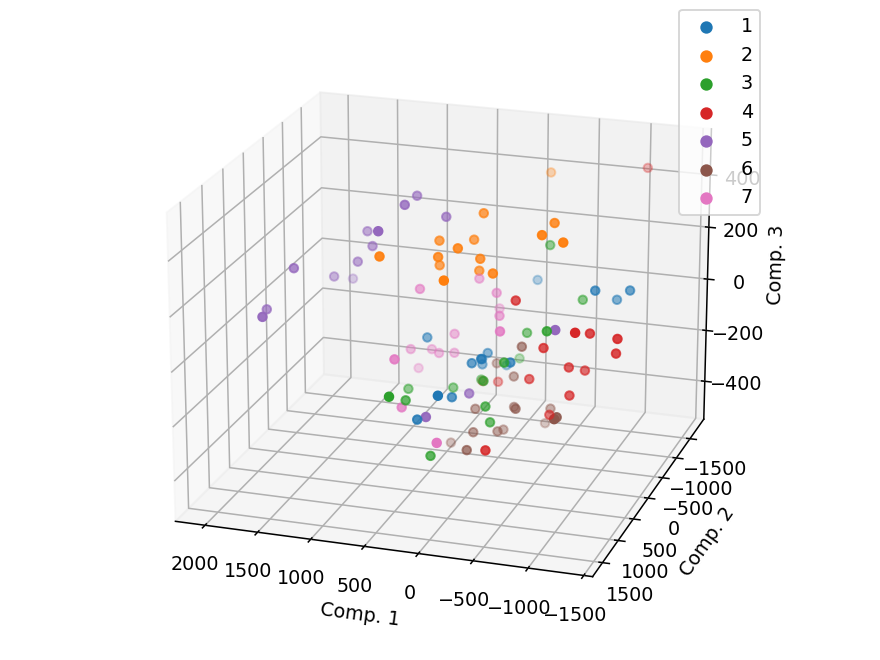

In [154]:
fig = plt.figure()
ax = Axes3D(fig, elev=48, azim=134)

for i in range(1, 8):
    ax.scatter(reduced_plane_tf[plane_test_target==i, 0], reduced_plane_tf[plane_test_target==i, 1], reduced_plane_tf[plane_test_target==i, 2], label=str(i))

lgnd = plt.legend()
ax.set_xlabel('Comp. 1')
ax.set_ylabel('Comp. 2')
ax.set_zlabel('Comp. 3')

for i in range(7):
    lgnd.legendHandles[i]._sizes = [30]

In [167]:
plt.close(fig)

## PCA for the car data

In [144]:
car_pca = PCA(n_components=3)
car_pca.fit(car_train_features)

PCA(n_components=3)

In [145]:
reduced_car_tf = car_pca.transform(car_test_features)

In [146]:
print(car_test_features.shape, reduced_car_tf.shape)

(60, 601) (60, 3)


<IPython.core.display.Javascript object>


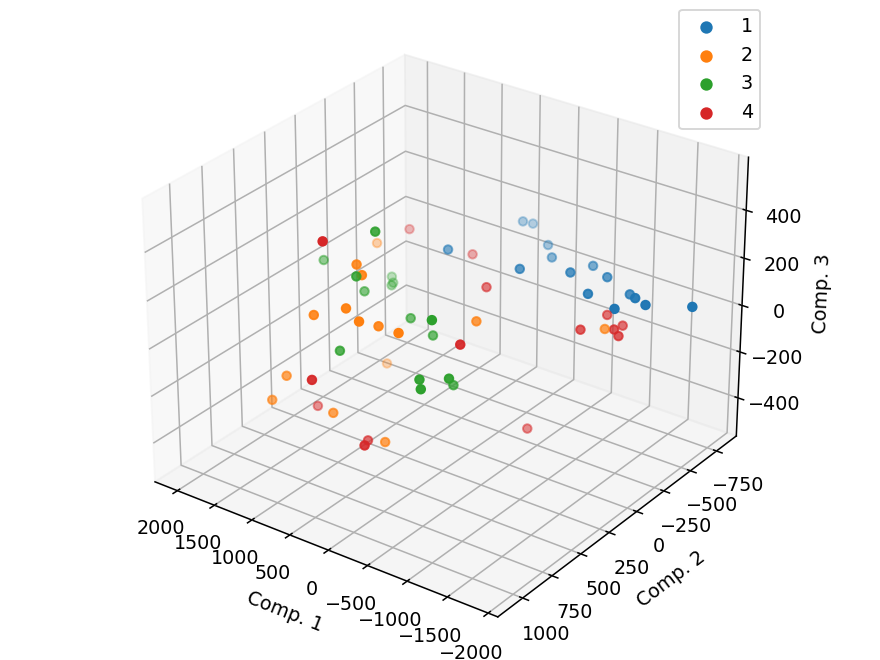

In [147]:
fig = plt.figure()
ax = Axes3D(fig, elev=48, azim=134)

for i in range(1, 5):
    ax.scatter(reduced_car_tf[car_test_target==i, 0], reduced_car_tf[car_test_target==i, 1], reduced_car_tf[car_test_target==i, 2], label=str(i))

lgnd = plt.legend()
ax.set_xlabel('Comp. 1')
ax.set_ylabel('Comp. 2')
ax.set_zlabel('Comp. 3')

for i in range(4):
    lgnd.legendHandles[i]._sizes = [30]

In [148]:
plt.close(fig)

# 6.2. Using TSNE

## TSNE for the plane data

In [165]:
plane_tsne = TSNE(n_components=3)
plane_tsne_trans3 = plane_tsne.fit_transform(plane_train_features)

<IPython.core.display.Javascript object>


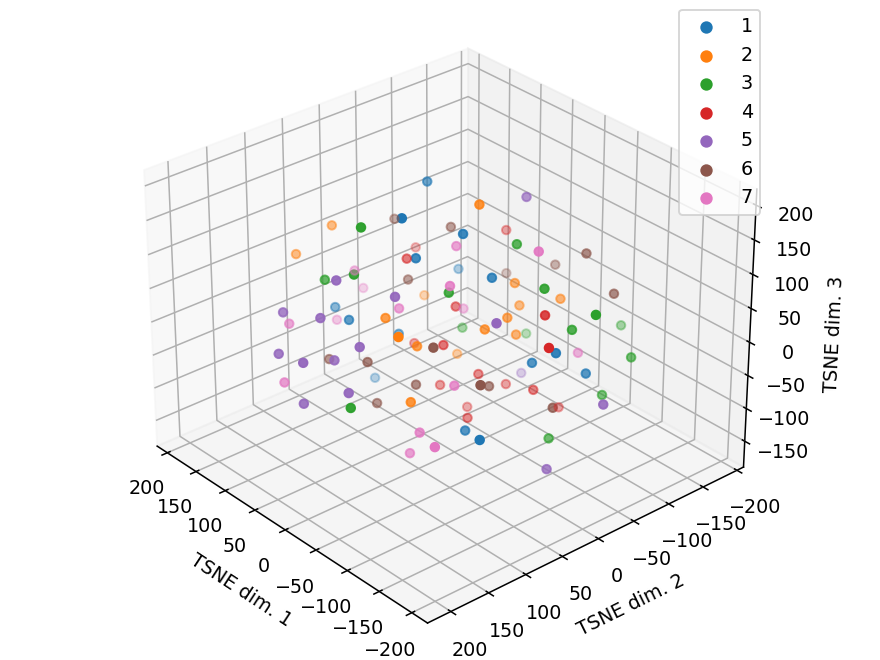

In [166]:
fig = plt.figure()
ax = Axes3D(fig, elev=48, azim=134)

for i in range(1, 8):
    ax.scatter(plane_tsne_trans3[plane_train_target==i, 0], plane_tsne_trans3[plane_train_target==i, 1], plane_tsne_trans3[plane_train_target==i, 2], label=str(i))

ax.set_xlabel('TSNE dim. 1')
ax.set_ylabel('TSNE dim. 2')
ax.set_zlabel('TSNE dim. 3')

lgnd = plt.legend()
for i in range():
    lgnd.legendHandles[i]._sizes = [30]

In [149]:
plt.close(fig)

## TSNE for the car data

In [155]:
car_tsne = TSNE(n_components=3)
car_tsne_trans3 = car_tsne.fit_transform(car_train_features)

In [156]:
fig = plt.figure()
ax = Axes3D(fig, elev=48, azim=134)

for i in range(1, 5):
    ax.scatter(car_tsne_trans3[car_train_target==i, 0], car_tsne_trans3[car_train_target==i, 1], car_tsne_trans3[car_train_target==i, 2], label=str(i))

ax.set_xlabel('TSNE dim. 1')
ax.set_ylabel('TSNE dim. 2')
ax.set_zlabel('TSNE dim. 3')

lgnd = plt.legend()
for i in range(4):
    lgnd.legendHandles[i]._sizes = [30]

<IPython.core.display.Javascript object>

In [157]:
plt.close(fig)

# 6.3. Using LDA

## LDA for the plane data

In [195]:
plane_lda = LinearDiscriminantAnalysis(n_components=3)
plane_lda_trans = plane_lda.fit_transform(plane_train_features, plane_train_target)

<IPython.core.display.Javascript object>


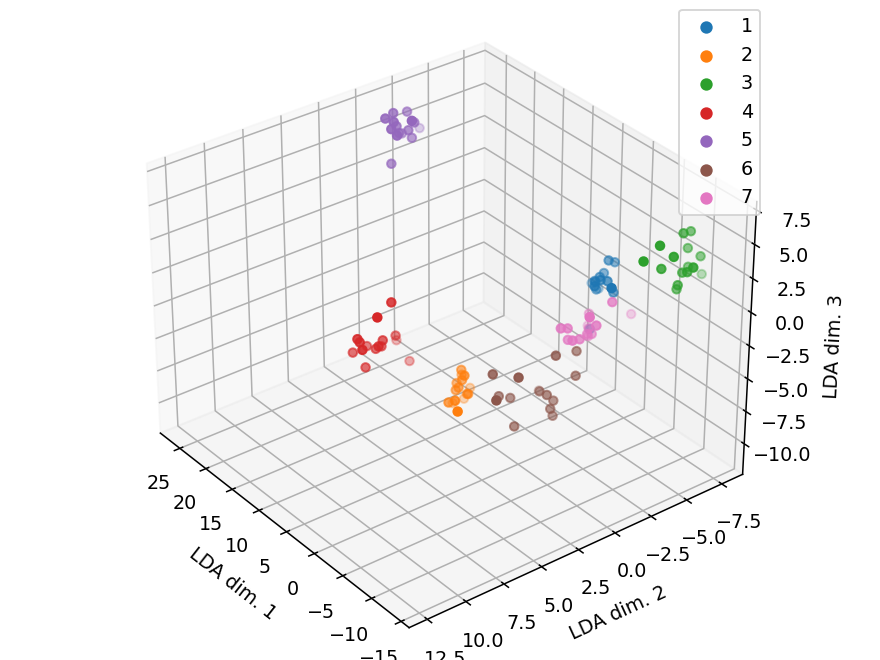

In [196]:
fig = plt.figure()
ax = Axes3D(fig, elev=48, azim=134)

for i in range(1, 8):
    ax.scatter(plane_lda_trans[plane_test_target==i, 0], plane_lda_trans[plane_test_target==i, 1], plane_lda_trans[plane_test_target==i, 2], label=str(i))

ax.set_xlabel('LDA dim. 1')
ax.set_ylabel('LDA dim. 2')
ax.set_zlabel('LDA dim. 3')

lgnd = plt.legend()
for i in range(7):
    lgnd.legendHandles[i]._sizes = [30]

In [149]:
plt.close(fig)

## LDA for the car data

In [197]:
car_lda = TSNE(n_components=3)
car_lda_trans = car_tsne.fit_transform(car_train_features, car_train_target)

<IPython.core.display.Javascript object>


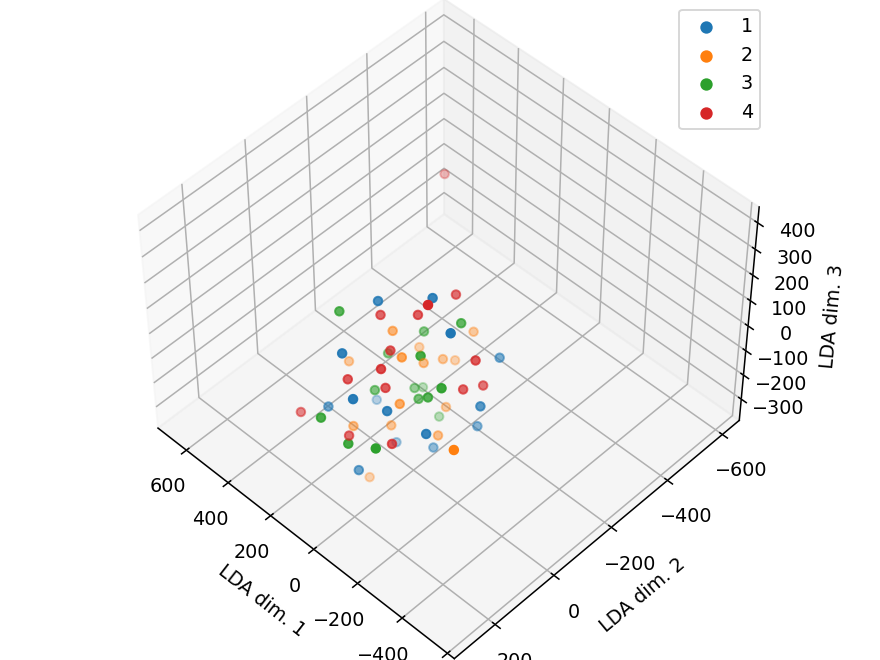

In [199]:
fig = plt.figure()
ax = Axes3D(fig, elev=48, azim=134)

for i in range(1, 5):
    ax.scatter(car_lda_trans[car_train_target==i, 0], car_lda_trans[car_train_target==i, 1], car_lda_trans[car_train_target==i, 2], label=str(i))

ax.set_xlabel('LDA dim. 1')
ax.set_ylabel('LDA dim. 2')
ax.set_zlabel('LDA dim. 3')

lgnd = plt.legend()
for i in range(4):
    lgnd.legendHandles[i]._sizes = [30]

In [157]:
plt.close(fig)

# 6.Using TPOT to generate optimal pipeline

## 6.1. TPOT for the plane data

In [188]:
tpot = TPOTClassifier(generations=5, population_size=10, verbosity=2, random_state=16)
tpot.fit(features=plane_train_features, target=plane_train_target)
tpot.fitted_pipeline_.steps
print(tpot.score(plane_test_features, plane_test_target))


Generation 1 - Current best internal CV score: 0.7428571428571429
Generation 2 - Current best internal CV score: 0.8666666666666666
Generation 3 - Current best internal CV score: 0.9047619047619048
Generation 4 - Current best internal CV score: 0.9523809523809523
Generation 5 - Current best internal CV score: 0.9523809523809523
Best pipeline: LinearSVC(input_matrix, C=10.0, dual=False, loss=squared_hinge, penalty=l1, tol=0.0001)
0.8761904761904762


## 6.2. TPOT for the car data

In [42]:
tpot = TPOTClassifier(generations=5, population_size=10, verbosity=2, random_state=16)
tpot.fit(features=car_train_features, target=car_train_target)
tpot.fitted_pipeline_.steps
print(tpot.score(car_test_features, car_test_target))


Generation 1 - Current best internal CV score: 0.65
Generation 2 - Current best internal CV score: 0.6500000000000001
Generation 3 - Current best internal CV score: 0.6500000000000001
Generation 4 - Current best internal CV score: 0.6500000000000001
Generation 5 - Current best internal CV score: 0.75
Best pipeline: GradientBoostingClassifier(MultinomialNB(input_matrix, alpha=100.0, fit_prior=True), learning_rate=0.5, max_depth=6, max_features=0.05, min_samples_leaf=5, min_samples_split=19, n_estimators=100, subsample=0.4)
0.8166666666666667


# Defining the classifiers
We define the three classifiers used.

In [173]:
plane_dt  = DecisionTreeClassifier()
plane_lda = LinearDiscriminantAnalysis()
plane_lg  = LogisticRegression()

In [174]:
car_dt  = DecisionTreeClassifier()
car_lda = LinearDiscriminantAnalysis()
car_lg  = LogisticRegression()

# Learning the classifiers
We used the train data to learn the three classifiers

In [175]:
# Ibon

plane_dt.fit(plane_train_features, plane_train_target)
plane_lda.fit(plane_train_features, plane_train_target)
plane_lg.fit(plane_train_features, plane_train_target)

/home/juletx/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [176]:
# Ibon

car_dt.fit(car_train_features, car_train_target)
car_lda.fit(car_train_features, car_train_target)
car_lg.fit(car_train_features, car_train_target)

/home/juletx/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

# Using the classifier for predictions
We predict the class of the samples in the test data with the three classifiers.

In [177]:
# Ibon

plane_dt_test_predictions = plane_dt.predict(plane_test_features)
plane_lda_test_predictions = plane_lda.predict(plane_test_features)
plane_lg_test_predictions = plane_lg.predict(plane_test_features)

In [178]:
# Ibon

car_dt_test_predictions = car_dt.predict(car_test_features)
car_lda_test_predictions = car_lda.predict(car_test_features)
car_lg_test_predictions = car_lg.predict(car_test_features)

# Computing the accuracy

Finally, we compute the accuracy using the three classifiers and print it. 

In [179]:
def print_accuracies(test_target, dt_test_predictions, lda_test_predictions, lg_test_predictions):
    dt_acc =  accuracy_score(test_target, dt_test_predictions)
    lda_acc =  accuracy_score(test_target, lda_test_predictions)
    lg_acc =  accuracy_score(test_target, lg_test_predictions)
    print("Accuracy for the decision tree :", dt_acc)
    print("Accuracy for LDA :", lda_acc)
    print("Accuracy for logistic regression:", lg_acc)

In [180]:
print_accuracies(plane_test_target, plane_dt_test_predictions, plane_lda_test_predictions, plane_lg_test_predictions)

Accuracy for the decision tree : 0.6476190476190476
Accuracy for LDA : 0.9238095238095239
Accuracy for logistic regression: 0.8285714285714286


In [181]:
print_accuracies(car_test_target, car_dt_test_predictions, car_lda_test_predictions, car_lg_test_predictions)

Accuracy for the decision tree : 0.7833333333333333
Accuracy for LDA : 0.8833333333333333
Accuracy for logistic regression: 0.8833333333333333


# Computing the confusion matrices
Finally we compute the confusion matrices for the three classifiers. We print the confusion matrices and also generate the latex code to insert it in our written report. 


In [185]:
def print_confusion_matrices(test_target, dt_test_predictions, lda_test_predictions, lg_test_predictions):
    print("Confusion matrix decision tree")
    cm_dt = pd.crosstab(test_target, dt_test_predictions)
    print(cm_dt)
    print()
    #cm_dt.to_latex()
    
    print("Confusion matrix LDA")
    cm_lda = pd.crosstab(test_target, lda_test_predictions)
    print(cm_lda)
    print()
    #cm_lda.to_latex()
    
    print("Confusion matrix Logistic regression")
    cm_lg = pd.crosstab(test_target, lg_test_predictions)
    print(cm_lg)
    print()
    #cm_lg.to_latex()

## 6.1. Confusion matrices for the plane data

In [186]:
print_confusion_matrices(plane_test_target, plane_dt_test_predictions, plane_lda_test_predictions, plane_lg_test_predictions)

Confusion matrix decision tree
[[ 9  0  4  0  0  2  0]
 [ 1  8  1  0  2  1  2]
 [ 2  0  4  1  0  4  4]
 [ 0  0  1 11  0  1  2]
 [ 0  0  0  2 13  0  0]
 [ 0  0  2  0  0 13  0]
 [ 3  0  1  0  1  0 10]]

Confusion matrix LDA
col_0   1   2   3   4   5   6   7
Class                            
1      12   0   3   0   0   0   0
2       0  14   0   0   1   0   0
3       0   0  15   0   0   0   0
4       0   0   0  14   0   0   1
5       0   1   0   0  14   0   0
6       0   0   0   0   0  15   0
7       1   0   0   1   0   0  13

Confusion matrix Logistic regression
col_0   1   2   3   4   5   6   7
Class                            
1      11   0   2   1   0   0   1
2       0  12   0   0   3   0   0
3       1   0  12   0   0   2   0
4       0   0   0  12   0   0   3
5       2   2   0   0  11   0   0
6       0   0   0   0   0  15   0
7       0   0   0   1   0   0  14



## 6.2. Confusion matrices for the car data

In [52]:
print_confusion_matrices(car_test_target, car_dt_test_predictions, car_lda_test_predictions, car_lg_test_predictions)

Confusion matrix decision tree
col_0   1  2  3   4
Class              
1      12  1  1   0
2       0  8  2   1
3       2  3  9   0
4       0  5  2  14

Confusion matrix LDA
col_0   1   2   3   4
Class                
1      13   1   0   0
2       0  11   0   0
3       0   3  10   1
4       2   0   3  16

Confusion matrix Logistic regression
col_0   1   2   3   4
Class                
1      12   1   0   1
2       1  10   0   0
3       0   1  13   0
4       0   1   5  15



In [53]:
##Applying Gaussian filter to our shapes
# Filtered with Gaussian filter (standar deviation = 10).
# Gaussian filter: https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.gaussian_filter.html
#for i in range(len(car_df['Contour_Coordinates'])):
#    car_df.at[i, 'Contour_Coordinates'] = gaussian_filter(np.array(car_df['Contour_Coordinates'][i]), sigma=10)
#print("This how our shapes filtered look like: \n")
#car_df

In [56]:
car_features

,Perimeter_length,x0,y0,x1,y1,x2,y2,x3,y3,x4,...,x295,y295,x296,y296,x297,y297,x298,y298,x299,y299
0,325,206,160,207,160,208,160,209,159,210,...,234,162,233,162,232,162,231,162,230,162
1,375,199,175,200,175,201,174,202,174,203,...,242,187,241,187,240,187,239,188,238,188
2,511,75,186,76,185,76,184,76,183,76,...,263,193,262,193,261,193,260,193,259,193
3,525,76,183,77,183,78,183,79,182,80,...,286,193,285,193,284,193,283,193,282,193
4,310,113,181,114,180,114,179,114,178,114,...,125,186,124,186,123,186,122,185,121,185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,369,39,178,40,177,41,177,42,178,43,...,89,188,88,188,87,189,86,190,85,190
116,339,145,176,146,176,147,175,147,174,148,...,172,190,171,191,170,190,169,190,168,190
117,578,4,200,5,199,6,198,7,198,8,...,241,160,241,161,241,162,241,163,241,164
118,334,54,184,55,183,56,183,57,183,58,...,82,192,81,192,80,192,79,192,78,192


# Feature Selection

At this point we have so many features: two features for each point in the contour perimeter. We normalized the length of each image to 300 points, so 300*2 = 600 features for representing each image. Let's try reducing this amount of features...

We are going to use SelectKBest + chi function for our feature selection process:

In [143]:
reduced_data_100 = SelectKBest(chi2, k=100).fit_transform(car_features, car_target)

reduced_data_200 = SelectKBest(chi2, k=200).fit_transform(car_features, car_target)

reduced_data_300 = SelectKBest(chi2, k=300).fit_transform(car_features, car_target)

reduced_data_400 = SelectKBest(chi2, k=400).fit_transform(car_features, car_target)

reduced_data_500 = SelectKBest(chi2, k=500).fit_transform(car_features, car_target)

As always, we need to separate the data in three: features data for training, features data for testing and class target:

In [144]:
reduced_data_train_100 = reduced_data_100[0::2]
reduced_data_test_100 = reduced_data_100[1::2]

reduced_data_train_200 = reduced_data_200[0::2]
reduced_data_test_200 = reduced_data_200[1::2]

reduced_data_train_300 = reduced_data_300[0::2]
reduced_data_test_300 = reduced_data_300[1::2]

reduced_data_train_400 = reduced_data_400[0::2]
reduced_data_test_400 = reduced_data_400[1::2]

reduced_data_train_500 = reduced_data_500[0::2]
reduced_data_test_500 = reduced_data_500[1::2]


car_train_target = car_target[0::2]
car_test_target = car_target[1::2]

It is better to create one classifier of each type not to mix them:

In [160]:
car_dt_100  = DecisionTreeClassifier()
car_lda_100 = LinearDiscriminantAnalysis()
car_lg_100  = LogisticRegression()

car_dt_200  = DecisionTreeClassifier()
car_lda_200 = LinearDiscriminantAnalysis()
car_lg_200  = LogisticRegression()

car_dt_300  = DecisionTreeClassifier()
car_lda_300 = LinearDiscriminantAnalysis()
car_lg_300  = LogisticRegression()

car_dt_400  = DecisionTreeClassifier()
car_lda_400 = LinearDiscriminantAnalysis()
car_lg_400  = LogisticRegression()

car_dt_500  = DecisionTreeClassifier()
car_lda_500 = LinearDiscriminantAnalysis()
car_lg_500  = LogisticRegression()

Fitting and predicting...

In [149]:
car_dt_100.fit(reduced_data_train_100, car_train_target)
car_lda_100.fit(reduced_data_train_100, car_train_target)
car_lg_100.fit(reduced_data_train_100, car_train_target)

car_dt_test_predictions_100 = car_dt_100.predict(reduced_data_test_100)
car_lda_test_predictions_100 = car_lda_100.predict(reduced_data_test_100)
car_lg_test_predictions_100 = car_lg_100.predict(reduced_data_test_100)

car_dt_200.fit(reduced_data_train_200, car_train_target)
car_lda_200.fit(reduced_data_train_200, car_train_target)
car_lg_200.fit(reduced_data_train_200, car_train_target)

car_dt_test_predictions_200 = car_dt_200.predict(reduced_data_test_200)
car_lda_test_predictions_200 = car_lda_200.predict(reduced_data_test_200)
car_lg_test_predictions_200 = car_lg_200.predict(reduced_data_test_200)

car_dt_300.fit(reduced_data_train_300, car_train_target)
car_lda_300.fit(reduced_data_train_300, car_train_target)
car_lg_300.fit(reduced_data_train_300, car_train_target)

car_dt_test_predictions_300 = car_dt_300.predict(reduced_data_test_300)
car_lda_test_predictions_300 = car_lda_300.predict(reduced_data_test_300)
car_lg_test_predictions_300 = car_lg_300.predict(reduced_data_test_300)

car_dt_400.fit(reduced_data_train_400, car_train_target)
car_lda_400.fit(reduced_data_train_400, car_train_target)
car_lg_400.fit(reduced_data_train_400, car_train_target)

car_dt_test_predictions_400 = car_dt_400.predict(reduced_data_test_400)
car_lda_test_predictions_400 = car_lda_400.predict(reduced_data_test_400)
car_lg_test_predictions_400 = car_lg_400.predict(reduced_data_test_400)

car_dt_500.fit(reduced_data_train_500, car_train_target)
car_lda_500.fit(reduced_data_train_500, car_train_target)
car_lg_500.fit(reduced_data_train_500, car_train_target)

car_dt_test_predictions_500 = car_dt_500.predict(reduced_data_test_500)
car_lda_test_predictions_500 = car_lda_500.predict(reduced_data_test_500)
car_lg_test_predictions_500 = car_lg_500.predict(reduced_data_test_500)

/home/ibon/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ibon/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

Let's see if the evolution of the accuracy depending on the quantity of fetures selected:

In [161]:
print("100 features: \n")
print_accuracies(car_test_target, car_dt_test_predictions_100, car_lda_test_predictions_100, car_lg_test_predictions_100)

100 features: 

Accuracy for the decision tree : 0.48333333333333334
Accuracy for LDA : 0.43333333333333335
Accuracy for logistic regression: 0.6166666666666667


In [162]:
print("200 features: \n")
print_accuracies(car_test_target, car_dt_test_predictions_200, car_lda_test_predictions_200, car_lg_test_predictions_200)

200 features: 

Accuracy for the decision tree : 0.5833333333333334
Accuracy for LDA : 0.65
Accuracy for logistic regression: 0.75


In [163]:
print("300 features: \n")
print_accuracies(car_test_target, car_dt_test_predictions_300, car_lda_test_predictions_300, car_lg_test_predictions_300)

300 features: 

Accuracy for the decision tree : 0.7833333333333333
Accuracy for LDA : 0.7333333333333333
Accuracy for logistic regression: 0.8


In [164]:
print("400 features: \n")
print_accuracies(car_test_target, car_dt_test_predictions_400, car_lda_test_predictions_400, car_lg_test_predictions_400)

400 features: 

Accuracy for the decision tree : 0.7666666666666667
Accuracy for LDA : 0.8
Accuracy for logistic regression: 0.8166666666666667


In [165]:
print("500 features: \n")
print_accuracies(car_test_target, car_dt_test_predictions_500, car_lda_test_predictions_500, car_lg_test_predictions_500)

500 features: 

Accuracy for the decision tree : 0.75
Accuracy for LDA : 0.8666666666666667
Accuracy for logistic regression: 0.8333333333333334
